# Linear regression example

This tutorial demonstrates the application of linear regression to test for QTL associations.

#### Set up environment

In [1]:
%matplotlib inline

import sys
import numpy as np
import scipy as sp
import scipy.stats as st
import pylab as pl
import pandas as pd
import h5py
sp.random.seed(0)

import limix.util as lmx_util
import limix.plot as lmx_plt

#### Download data

We here load the yeast cross dataset.
The data used in this study have been preconverted into an hdf5 file. 
To process your own data, please use the limix command line binary.

In [2]:
sys.path.append('./..')
import data as tutorial_data
file_name = tutorial_data.get_file('BYxRM')

#### Set up data object

Phenotypes and genotypes are stored inside the HDF5 file. Load them into a dataframe and select the first 3 phenotypes. 

In [3]:
f = h5py.File(file_name, 'r')
pheno_group = f['phenotype']
pheno_df = pd.DataFrame(pheno_group['matrix'][:], 
                        columns=pheno_group['col_header']['phenotype_ID'][:],
                        index=pheno_group['row_header']['sample_ID'][:]).iloc[:,:3]

In [4]:
pheno_df.head()

,Cadmium_Chloride,Caffeine,Calcium_Chloride
A01_01,-7.323520,0.279993,0.313118
A01_02,-8.098236,-0.206326,-0.534844
A01_03,7.605720,-0.127960,-0.311102
A01_04,-6.147649,0.878392,-0.563331
A01_05,9.379060,-1.353169,0.405204


In [5]:
geno_group = f['genotype']
chromosomes = geno_group['col_header']['chrom'][:]
positions = geno_group['col_header']['pos'][:]
geno_df = pd.DataFrame(geno_group['matrix'][:], columns=positions, 
                       index=geno_group['row_header']['sample_ID'][:], dtype='int64')

In [6]:
geno_df.head()

,27915,28323,28652,29667,30756,31059,31213,31636,31756,31976,...,925487,925742,926177,927903,928103,929518,929724,930545,931289,931944
A01_01,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
A01_02,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
A01_03,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,1,1,1
A01_04,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
A01_05,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [7]:
#Remove NaNs
filtered_pheno_df = pheno_df.dropna()
filtered_pheno_df.info()
sample_idx = geno_df.index.intersection(filtered_pheno_df.index)

<class 'pandas.core.frame.DataFrame'>
Index: 785 entries, A01_01 to A11_93
Data columns (total 3 columns):
Cadmium_Chloride    785 non-null float64
Caffeine            785 non-null float64
Calcium_Chloride    785 non-null float64
dtypes: float64(3)
memory usage: 24.5+ KB


In [8]:
#phenotype
phenotype_ID = pheno_df.columns.values
phenotype_vals = filtered_pheno_df

N = geno_df.shape[0] #number of individuals
S = geno_df.shape[1] #number of SNPs
P = phenotype_vals.shape[1]#number of phenotypes

# retrieve indices for filtered accessions

## Normal distributed phenotypes and phenotype transformations

To explore the phenotypic data, we create a histogram of the phenotype values.

/Users/mhorto/miniconda2/envs/gwas/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 216x216 with 0 Axes>

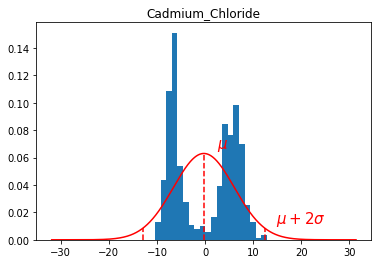

<Figure size 216x216 with 0 Axes>

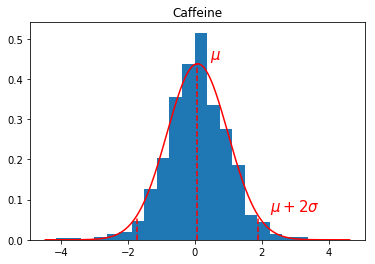

<Figure size 216x216 with 0 Axes>

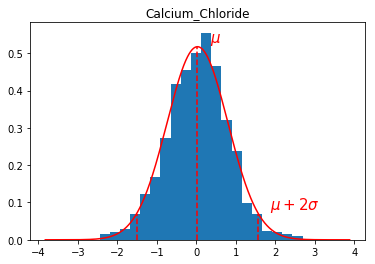

In [9]:
for ip, p_ID in enumerate(phenotype_ID):
    pl.figure(figsize=[3,3])#create the figure
    
    #histogram of the untransformed phenotypes
    lmx_plt.plot_normal(phenotype_vals.values[:,ip])
    pl.title("%s" % p_ID)

Some of the phenotypes deviate from a normal distribution.
One of the assumptions of the linear regression model we use for association testing is that the model residuals are normal distrbuted.
Violation of this assumption leads to biases in the analysis.
We only have access to the residuals after fitting the model.
Under the assumption that the model eplains only a small portion of phenotypic variation we can assess the phenotype values instead.

### Transforming phenotypes

To make the data look more normal distrbuted, we apply two different phenotype transformations, the Box-Cox transformation and a non-parametric rank-based transformation.

#### Box-Cox transformation

The Box-Cox transformation makes the data "more normal" by fitting a power transformation with one parameter to the observed phenotypic data.

In [10]:
phenotype_vals_boxcox, maxlog = lmx_util.preprocess.boxcox(phenotype_vals.values)

#### Rank-based (non-parametric) transformation

The rank-based transformation makes the data look absolutely normal by converting the data first to ranks and then transforming it to the corresponding quantiles of a normal distribution. As this transformation does not have a parameter (or actually one parameter per sample, namely the normal quantile), it is called non-paramteric.

In [11]:
phenotype_vals_ranks = lmx_util.preprocess.rankStandardizeNormal(phenotype_vals.values)

Let's look at the histograms after transformation:

<Figure size 720x216 with 0 Axes>

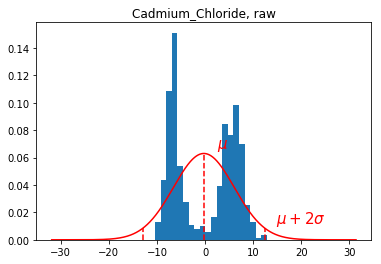

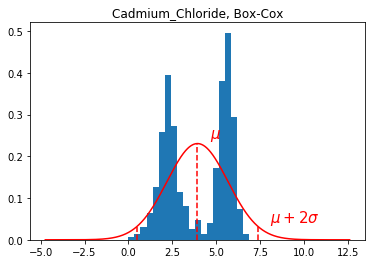

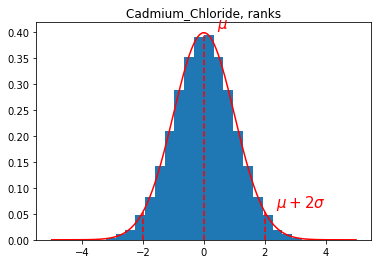

<Figure size 720x216 with 0 Axes>

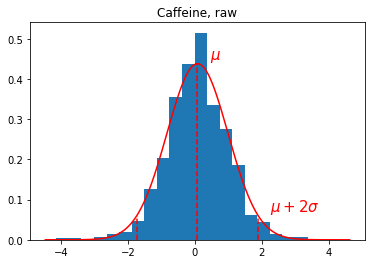

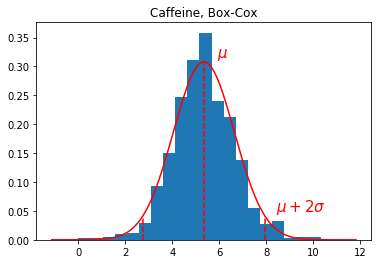

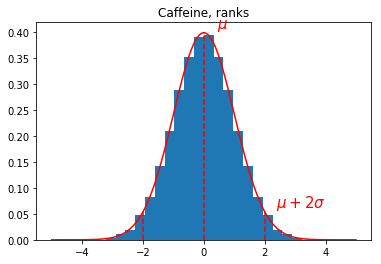

<Figure size 720x216 with 0 Axes>

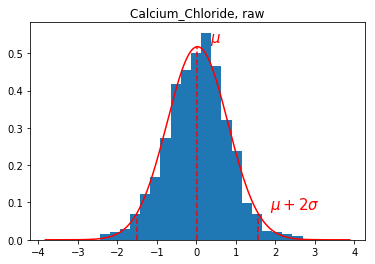

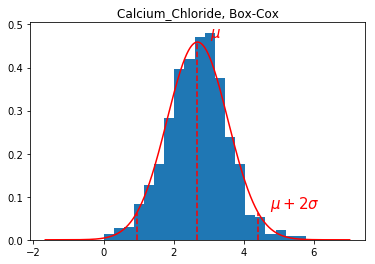

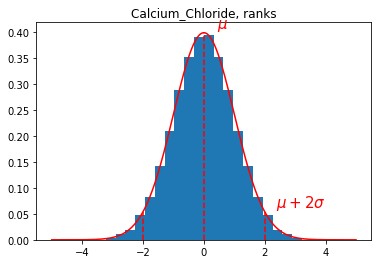

In [12]:
for ip, p_ID in enumerate(phenotype_ID):
    pl.figure(figsize=[10,3])#create the figure
    
    #untransformed phenotypes
    lmx_plt.plot_normal(phenotype_vals.values[:,ip])
    pl.title("%s, raw" % p_ID)
    
    #boxcox-transformed phenotypes
    lmx_plt.plot_normal(phenotype_vals_boxcox[:,ip])
    pl.title("%s, Box-Cox" % p_ID)
    
    #the rank-normalized phenotypes
    lmx_plt.plot_normal(phenotype_vals_ranks[:,ip])
    pl.title("%s, ranks" % p_ID)

### GWAS testing using linear regression on the original phenotype:

The function for linear regression in LIMIX is ``limix.qtl.qtl_test_lm`` (see [here][1]).

[1]:http://limix.readthedocs.io/qtl.html#limix.qtl.qtl_test_lm

In [13]:
from limix.qtl import qtl_test_lm

#run linear regression on each SNP
lm = qtl_test_lm(snps=geno_df.loc[sample_idx].values, pheno=phenotype_vals.values)
pv = lm.getPv() # get P values
beta = lm.getBetaSNP() # get effect sizes
beta_ste = lm.getBetaSNPste() # get standard errors

For nice output writing, we here convert P-values to a DataFrame:

In [14]:
pvalues_lm = pd.DataFrame(pv.T, index=positions,
                          columns=phenotype_ID)
pvalues_lm.head()

,Cadmium_Chloride,Caffeine,Calcium_Chloride
27915,0.552389,0.921219,0.105373
28323,0.586922,0.903911,0.109003
28652,0.542816,0.950267,0.122746
29667,0.568640,0.840404,0.157083
30756,0.530018,0.894559,0.155157


#### Manhattan plot

A common way to visualize the results of a GWAS is a Manhatten plot, where the $-log_{10}$ P-values are plotted against the genomic position.

The LIMIX function for producing Manhattan plots is ``limix.plot.plot_manhattan`` (see [here][1]).

[1]:https://limix.readthedocs.io/en/stable/_modules/limix/plot/manhattan.html

In [15]:
def no_annotate(*args):
    pass
from limix.plot import manhattan
manhattan._annotate = no_annotate

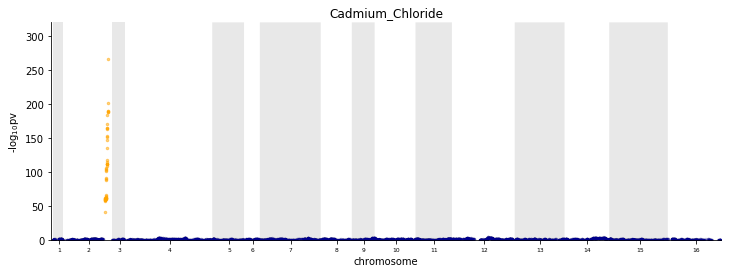

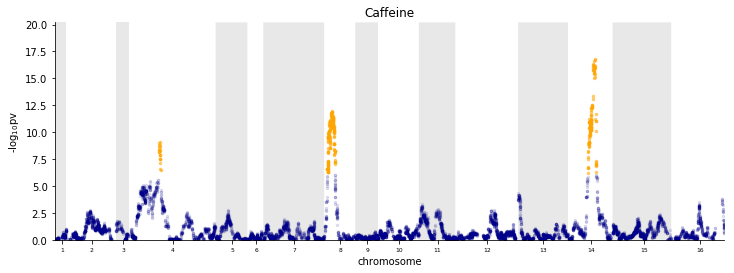

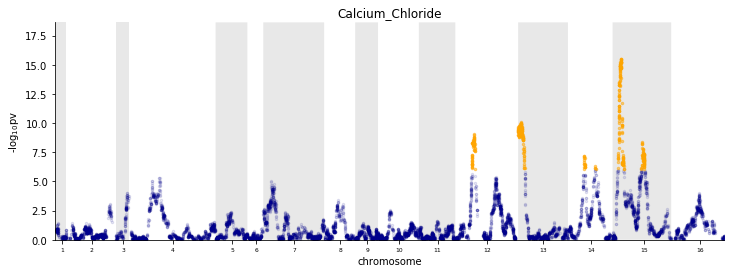

In [16]:
# Genome-wide manhatton plots for one phenotype:
for ip, p_ID in enumerate(phenotype_ID):
    pl.figure(figsize=[12,4])
    lmx_plt.plot_manhattan(pd.DataFrame(dict(pv=pvalues_lm[p_ID].values,chrom=chromosomes,pos=positions)))
    pl.title(p_ID)

### Observations:

* Several peaks are visible.

* The peaks entail multiple neighboring SNPs due to linkage disequilibrium to the causal variant.

##### GWAS using linear regression on the transformed phenotypes:

First we analyze the Box-Cox transformed phenotypes.

In [17]:
#run linear regression on each SNP
lm_boxcox = qtl_test_lm(snps=geno_df.loc[sample_idx].values,pheno=phenotype_vals_boxcox)
pv_boxcox = lm_boxcox.getPv()

#convert P-values to a DataFrame for nice output writing:
pvalues_lm_boxcox = pd.DataFrame(data=pv_boxcox.T,index=positions,
                          columns=phenotype_ID)

Next, we analyze the phenotypes transformed by the rank-based transformation.

In [18]:
#run linear regression on each SNP
lm_ranks = qtl_test_lm(snps=geno_df.loc[sample_idx].values,pheno=phenotype_vals_ranks)
pv_ranks = lm_ranks.getPv()

#convert P-values to a DataFrame for nice output writing:
pvalues_lm_ranks = pd.DataFrame(data=pv_ranks.T,index=positions,
                          columns=phenotype_ID)

To compare the results on the various transformations and the orignial data, we create correlation plots between the P-values.

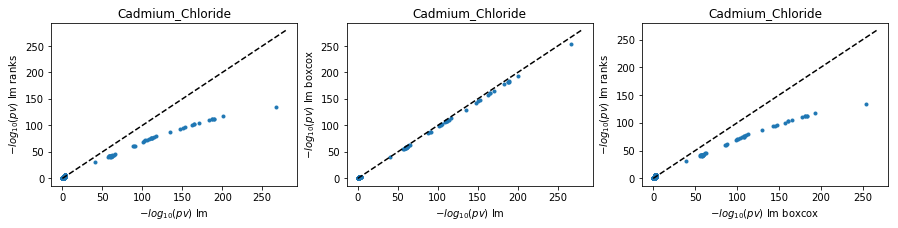

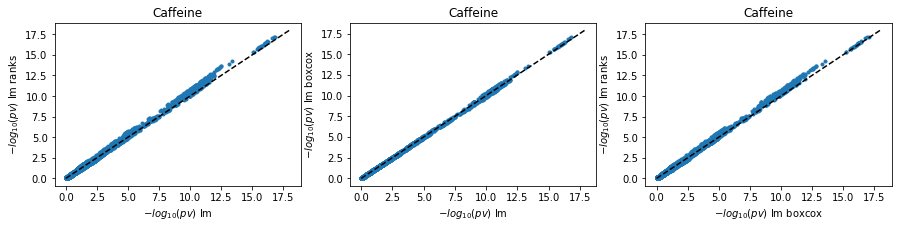

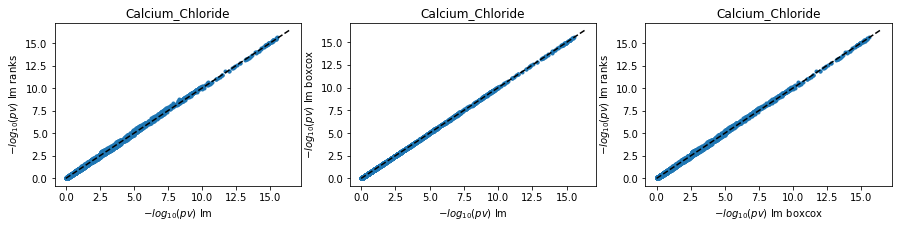

In [19]:
for ip, p_ID in enumerate(phenotype_ID):
    pl.figure(figsize=[15,3])#create the figure
    pl.subplot(1,3,1)
    pl.plot(-sp.log10(pvalues_lm[p_ID].values),-sp.log10(pvalues_lm_ranks[p_ID].values),'.')
    pl.xlabel('$-log_{10}(pv)$ lm')
    pl.ylabel('$-log_{10}(pv)$ lm ranks')
    pl.title(p_ID)
    max_range = max(pl.xlim()[1],pl.ylim()[1])
    pl.plot([0,max_range],[0,max_range],'k--')
    pl.subplot(1,3,2)
    pl.plot(-sp.log10(pvalues_lm[p_ID].values),-sp.log10(pvalues_lm_boxcox[p_ID].values),'.')
    pl.xlabel('$-log_{10}(pv)$ lm')
    pl.ylabel('$-log_{10}(pv)$ lm boxcox')
    max_range = max(pl.xlim()[1],pl.ylim()[1])
    pl.plot([0,max_range],[0,max_range],'k--')
    pl.title(p_ID)
    pl.subplot(1,3,3)
    pl.plot(-sp.log10(pvalues_lm_boxcox[p_ID].values),-sp.log10(pvalues_lm_ranks[p_ID].values),'.')
    pl.xlabel('$-log_{10}(pv)$ lm boxcox')
    pl.ylabel('$-log_{10}(pv)$ lm ranks')
    pl.title(p_ID)

    max_range = max(pl.xlim()[1],pl.ylim()[1])
    pl.plot([0,max_range],[0,max_range],'k--')
    


Next, we look at the residuals at the strongest associated SNP by plotting the phenotype values against the SNP values.

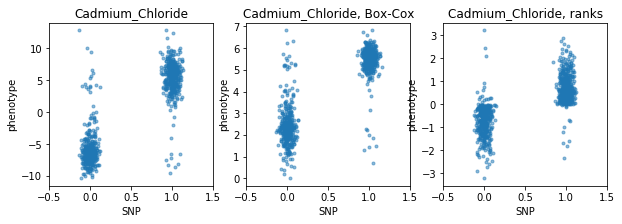

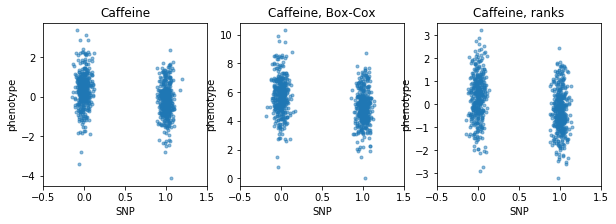

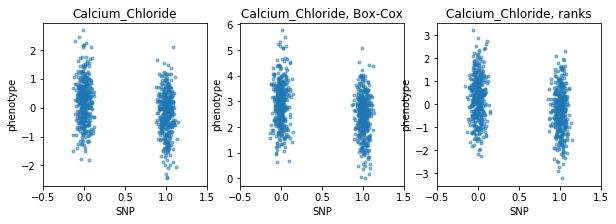

In [20]:
for ip, p_ID in enumerate(phenotype_ID):
    pl.figure(figsize=[10,3])#create the figure
    
    plt = pl.subplot(1,3,1)#the untransformed phenotypes
    #find maximum squared beta value
    pheno_vals = filtered_pheno_df[p_ID]
    s_idx = geno_df.index.intersection(pheno_vals.index)
    
    imax = lm.pvalues[ip].argmin()
    #snp = geno_df.loc[s_idx][geno_df.columns[imax]]
    snp = geno_df.loc[sample_idx][geno_df.columns[imax]]

    #plot SNP vs. phenotype for max beta
    
    pl.plot(snp+0.05*sp.randn(snp.shape[0]),pheno_vals.values,'.',alpha=0.5)
    
    pl.xlabel("SNP")
    pl.ylabel("phenotype")
    pl.xlim([-0.5,1.5])
    pl.title("%s" % p_ID)

    plt = pl.subplot(1,3,2)#the Box-Cox transformed phenotypes
    pl.plot(snp+0.05*sp.randn(snp.shape[0]),phenotype_vals_boxcox[:,ip],'.',alpha=0.5)
    
    pl.xlabel("SNP")
    pl.ylabel("phenotype")
    pl.xlim([-0.5,1.5])
    pl.title("%s, Box-Cox" % p_ID)
    
    plt = pl.subplot(1,3,3)#the rank transformed phenotypes
    pl.plot(snp+0.05*sp.randn(snp.shape[0]),phenotype_vals_ranks[:,ip],'.',alpha=0.5)
    
    #pl.plot([0,1],[pheno_vals.values[i_0].mean(),pheno_vals.values[~i_0].mean()])
    pl.xlabel("SNP")
    pl.ylabel("phenotype")
    pl.xlim([-0.5,1.5])
    pl.title("%s, ranks" % p_ID)
    

There is an interesting artifact visible from the rank-transformation. On the original data there are two peaks visible. By making the data look normal distributed, the two peaks are merged together. Once conditioning on the strongest SNP, which seems to have a Mendelian effect on the phenotype, the residuals become less normal distributed than for the original data.

## Assessing the P-value distribution

P-values corresponding to truly null hypotheses (that is, of no association) should be uniformly distributed between 0 and 1.

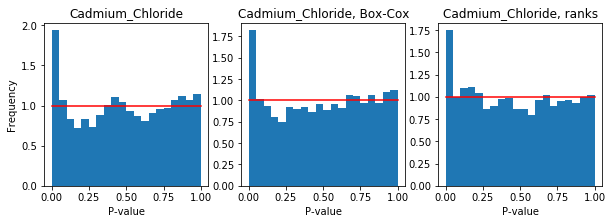

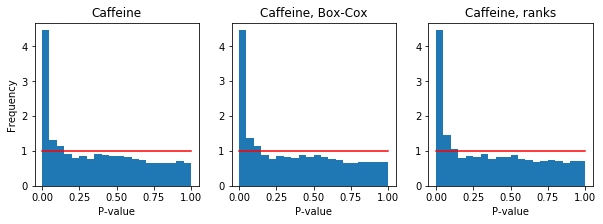

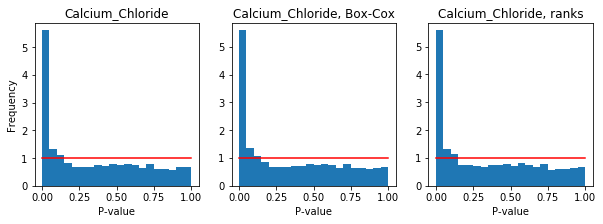

In [21]:
# P-value histgrams

for ip, p_ID in enumerate(phenotype_ID):
    pl.figure(figsize=[10,3])
    
    plt = pl.subplot(1,3,1)
    pl.hist(pvalues_lm[p_ID].values,20,normed=True)
    pl.plot([0,1],[1,1],"r")
    pl.title("%s" % p_ID)
    pl.xlabel("P-value")
    pl.ylabel("Frequency")
    
    plt = pl.subplot(1,3,2)
    pl.hist(pvalues_lm_boxcox[p_ID].values,20,normed=True)
    pl.plot([0,1],[1,1],"r")
    pl.title("%s, Box-Cox" % p_ID)
    pl.xlabel("P-value")
    
    plt = pl.subplot(1,3,3)
    pl.hist(pvalues_lm_ranks[p_ID].values,20,normed=True)
    pl.plot([0,1],[1,1],"r")
    pl.title("%s, ranks" % p_ID)
    pl.xlabel("P-value")
    
    

Overall, these histograms show a large number of uniformly distributed P-values. However, there are also small P-values.

#### P-value Quantile-Quantile plots

Comparing the quantiles of the negative log P-values to the negative log uniform quantiles, the excess number of small P-values becomes even more visible (see next section).

The function in LIMIX to produce QQ plots is ``limix.plot.qqplot`` (see [here][1]).

Question:

* How would you explain these non-uniform P-value distributions?

[1]:https://limix.readthedocs.io/en/stable/_modules/limix/plot/qqplot.html

/Users/mhorto/miniconda2/envs/gwas/lib/python2.7/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


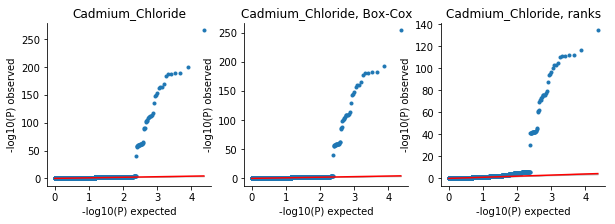

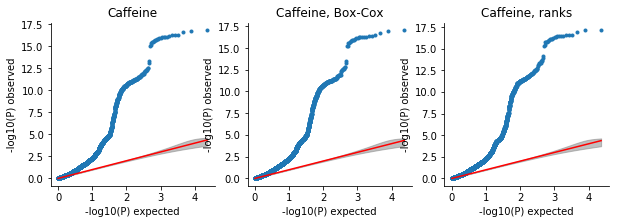

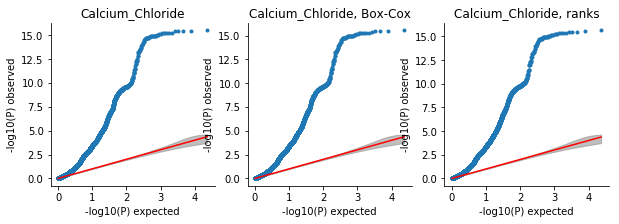

In [22]:
# Quantile-Quantile plots

for ip, p_ID in enumerate(phenotype_ID):
    pl.figure(figsize=[10,3])
    
    plt = pl.subplot(1,3,1)
    lmx_plt.qqplot(pvalues_lm[p_ID].values)
    pl.title("%s" % p_ID)
    
    plt = pl.subplot(1,3,2)
    lmx_plt.qqplot(pvalues_lm_boxcox[p_ID].values)
    pl.title("%s, Box-Cox" % p_ID)
    
    plt = pl.subplot(1,3,3)
    lmx_plt.qqplot(pvalues_lm_ranks[p_ID].values)
    pl.title("%s, ranks" % p_ID)
    

The grey area in the plots marks the $\alpha=0.01$ confidence interval for the hypothesis that a P-value comes from the null distribution.

## Permutation tests

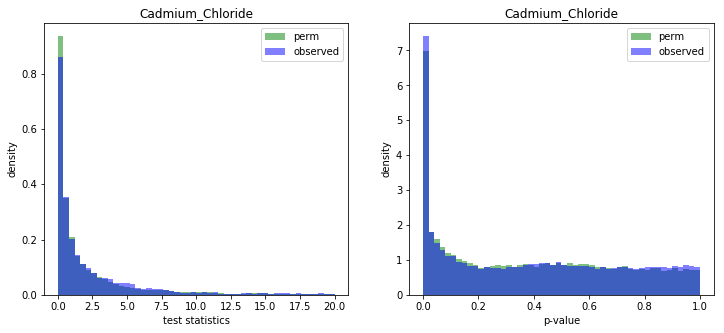

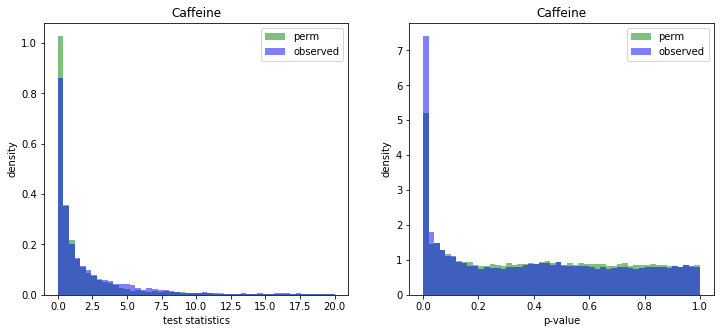

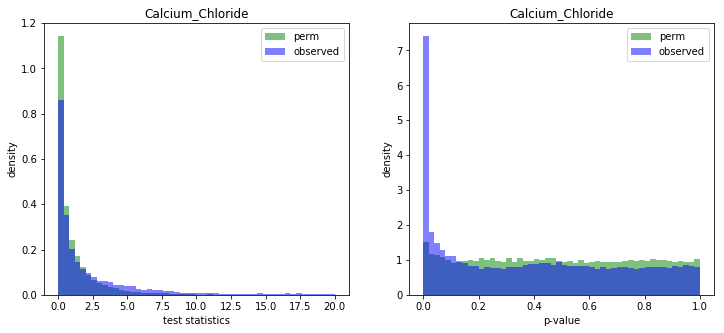

In [23]:
"""
computing test statistics on permuted data
"""
phenotype_vals_perm = phenotype_vals.copy()

for ip, p_ID in enumerate(phenotype_ID):
    perm = sp.random.permutation(phenotype_vals[p_ID].values)
    phenotype_vals_perm[p_ID] = perm
  
    #run linear regression on each SNP on permutated and non-permuted data
    lm = qtl_test_lm(snps=geno_df.loc[sample_idx].values,pheno=phenotype_vals.values)
    lm_perm = qtl_test_lm(snps=geno_df.loc[sample_idx].values,pheno=phenotype_vals_perm.values)
    
    #plot
    fig = pl.figure(figsize=[12,5])
    pl.subplot(1,2,1)
    pl.hist(lm_perm.test_statistics.flatten(),normed=True,color='g',alpha=0.5,bins=50,range=(0,20),label='perm')
    pl.hist(lm.test_statistics[1],normed=True,color='b',alpha=0.5,bins=50,range=(0,20),label='observed')
    pl.xlabel('test statistics')
    pl.ylabel('density')
    pl.title(p_ID)

    pl.legend()
    pl.subplot(1,2,2)
    p=pl.hist(lm_perm.pvalues.flatten(),normed=True,color='g',alpha=0.5,bins=50,range=(0,1),label='perm')
    p=pl.hist(lm.pvalues.flatten(),normed=True,color='b',alpha=0.5,bins=50,range=(0,1),label='observed')
    pl.title(p_ID)
    pl.xlabel('p-value')
    pl.ylabel('density')
    pl.legend()

## False discovery rates

False discovery rates (FDR) give an idea of the expected type-1 error rate at a given P-value threshold. If we are testing millions of hypotheses, then we might be willing to accept type-1 errors at a given rate, if in return we get more discoveries.

This measure gives a useful alternative to traditional Bonferroni correction, which bounds the so-called family-wise error rate (FWER), namely the probability of having at least a single type 1 error.

#### $q$-values

Definition: minimum false discovery rate threshold that would allow the variable to be significant.

In the following we are computing $q$-values for each SNP first on the original data and then on permuted data. By permuting the data we break any dependence between the SNP and the phenotype, making the data come from the null distribution (no association).

The limix function to compute q-values is ``limix.stats.qvalues`` (see [here][1] for details on usage).

[1]:http://limix.readthedocs.io/stats.html#limix.stats.qvalues

(0, 10)

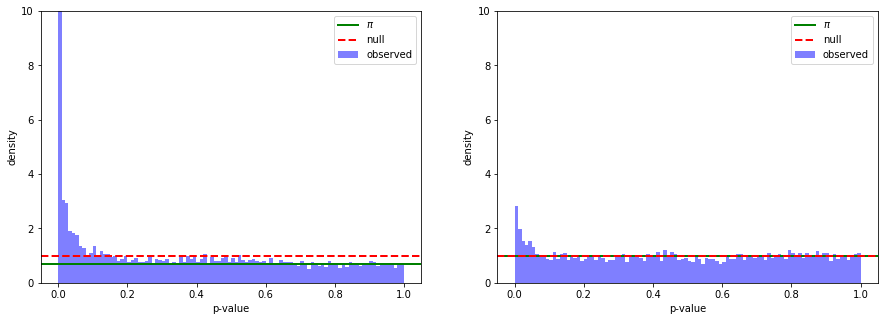

In [24]:
from limix.stats import qvalues
fig = pl.figure(3,figsize=[15,5])

#1. on the real tests
pl.subplot(1,2,1)
qv, pi0 = qvalues(lm.pvalues[1], return_pi0=True)
#plot distribution of p-values and fitted \pi parameter:
fig = pl.figure(3,figsize=[8,5])
pl.hist(lm.pvalues[1],bins=100,normed=True,color='b',label='observed',alpha=0.5)
pl.axhline(pi0,color='g',linewidth=2,label='$\pi$')
pl.axhline(1,color='r',linestyle='--',linewidth=2,label='null')
pl.legend()
pl.xlabel('p-value')
pl.ylabel('density')
pl.ylim((0,10))

#2. on permuted p-values
pl.subplot(1,2,2)
qv_perm, pi0 = qvalues(lm_perm.pvalues[1], return_pi0=True)
#plot distribution of p-values and fitted \pi parameter:
pl.hist(lm_perm.pvalues[1],bins=100,normed=True,color='b',label='observed',alpha=0.5)
pl.axhline(pi0,color='g',linewidth=2,label='$\pi$')
pl.axhline(1,color='r',linestyle='--',linewidth=2,label='null')
pl.legend()
pl.xlabel('p-value')
pl.ylabel('density')
pl.ylim((0,10))

To compare the differences and similarities between multiple hypothesis correctin via the false discovery rate and the family-wise error rate, we plot q-values (estimated by the Benjamini and Hochberg procedure) and the family-wise error rate (upper bounded by the Bonferoni method)

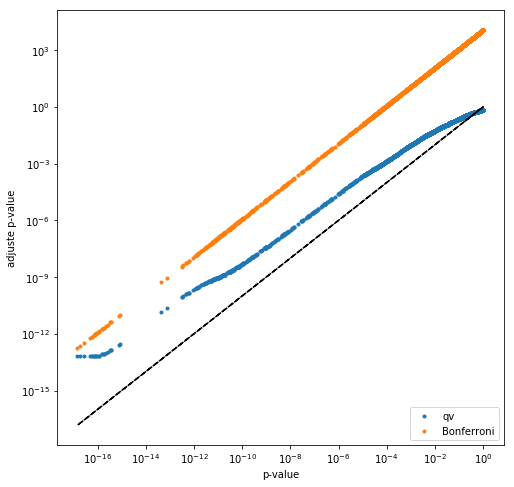

In [25]:
# compare q-values against p-values and Bonferroni adjustement:
pl.figure(figsize=[8,8])
pl.plot((lm.pvalues[1]),(qv),'.',label = 'qv')
pl.plot((lm.pvalues[1]),(lm.pvalues[1]*geno_df.shape[1]),'.',label = 'Bonferroni')
pl.plot(lm.pvalues[1],lm.pvalues[1],'k--')
pl.yscale("log")
pl.xscale("log")
pl.xlabel('p-value')
pl.ylabel('adjuste p-value')
pl.legend(loc='lower right')

An interesting observation is that for a single significant SNP, the false discovery rate and the family-wise error rate are the same, whereas they start to differ when loweringt the significance threshold.

### Conditional analysis

For the phenotype Cadmium Chloride there was one very large effect visisble. In th efollowing we perform a conditional analysis to find additional secondary associations.

Note that all the phenotypes condition on the same SNP, that has an association to the first phenotype only.

In [26]:
#create a matrix of covariates, one being the SNP to condition on 
#and a constant vector of ones representing the bias term.
imax = lm.pvalues[0].argmin()

covars_conditional= sp.concatenate((geno_df.loc[sample_idx].values[:,imax:imax+1], sp.ones((phenotype_vals.values.shape[0],1))),1)
                                  

#run linear regression on each SNP
lm_conditional = qtl_test_lm(snps=geno_df.loc[sample_idx].values,pheno=phenotype_vals.values,covs=covars_conditional)

#convert P-values to a DataFrame for nice output writing:
pvalues_lm_conditional = pd.DataFrame(data=lm_conditional.pvalues.T,index=positions,
                       columns=phenotype_ID)

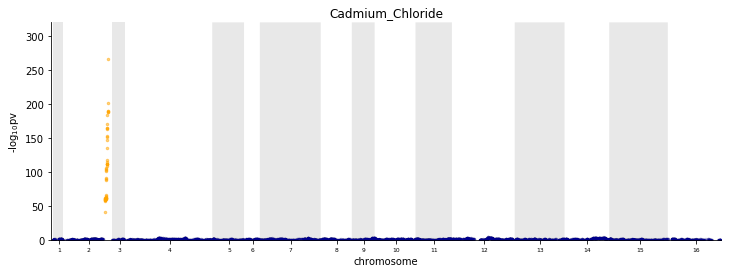

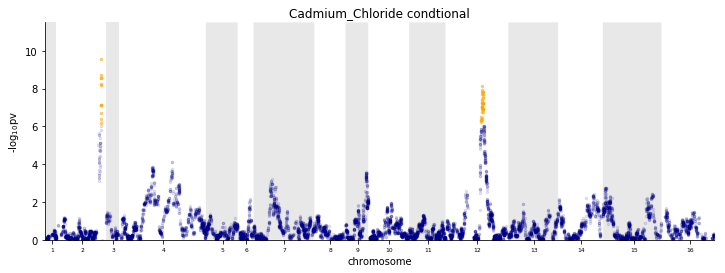

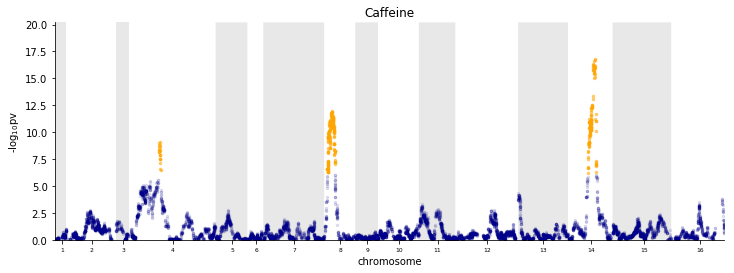

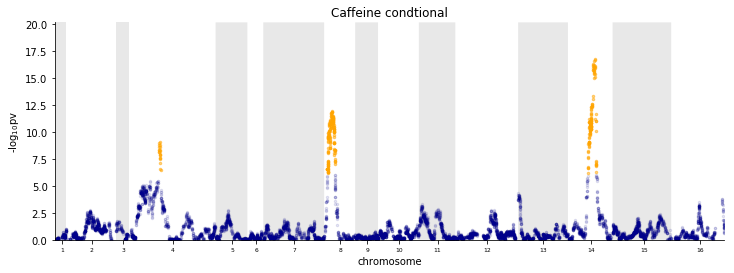

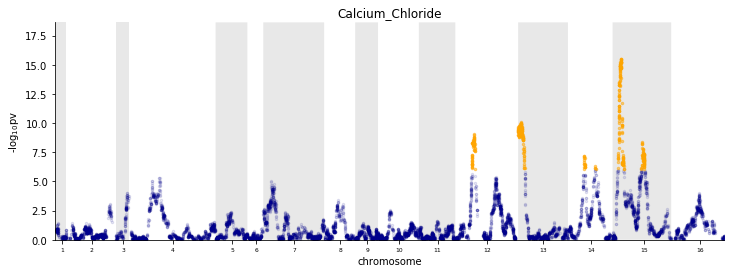

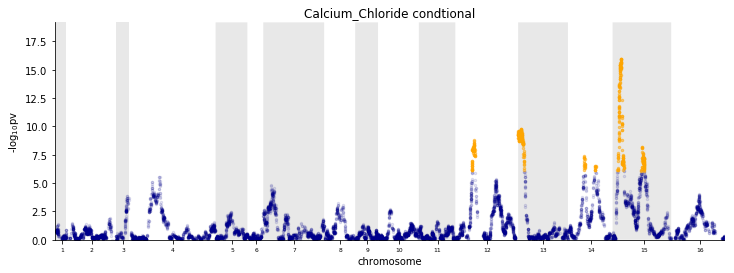

In [27]:
for ip, p_ID in enumerate(phenotype_ID):

    # before conditioninng
    pl.figure(figsize=[12,4])
    pl.title(p_ID)
    lmx_plt.plot_manhattan(pd.DataFrame(dict(pv=pvalues_lm[p_ID].values,chrom=chromosomes,pos=positions)))

    # after conditioning
    pl.figure(figsize=[12,4])
    pl.title(p_ID+" condtional")
    lmx_plt.plot_manhattan(pd.DataFrame(dict(pv=pvalues_lm_conditional[p_ID].values,chrom=chromosomes,pos=positions)))
    

Observation: For all but the associated phenotype the conditional analysis looks almost identical to the original analysis.